In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


2024-05-12 18:47:04.547828: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 18:47:04.550882: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 18:47:04.589200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 18:47:05.265271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)

2.16.1


In [3]:
train = pd.read_csv('data/fmnist_train.csv')

val = pd.read_csv('data/fmnist_test.csv')
print(train.shape, val.shape, sep='\n')

(17040, 786)
(10000, 785)


In [4]:
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
count,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,...,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17039.000000,17040.000000
mean,4.486913,0.002347,0.005869,0.028991,0.114495,0.233275,0.372946,0.725352,2.167077,5.751995,...,23.532308,16.799519,17.331886,22.342332,17.985328,8.849111,2.964435,0.961265,0.088738,8519.500000
std,2.881984,0.172991,0.209439,0.621885,2.630319,4.060619,5.337305,7.395038,13.906113,24.238699,...,48.730232,41.825340,43.064804,51.111173,45.379001,30.228846,18.003959,9.866697,2.342414,4919.168629
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4259.750000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8519.500000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12779.250000
max,9.000000,16.000000,16.000000,56.000000,164.000000,217.000000,230.000000,213.000000,218.000000,254.000000,...,255.000000,254.000000,255.000000,252.000000,255.000000,250.000000,255.000000,255.000000,170.000000,17039.000000


Датасет состоит из следующих признаков:

* *label* - класс изображения:

    - **0** T-shirt/top – футболка
    
    - **1** Trouser – брюки
    
    - **2** Pullover – свитер
    
    - **3** Dress – платье
    
    - **4** Coat – пальто
    
    - **5** Sandal – сандалия
    
    - **6** Shirt – рубашка
    
    - **7** Sneaker – кроссовок
    
    - **8** Bag – сумка
    
    - **9** Ankle boot – сапог

* *id* - уникальный номер

* *pixel*[num] - пиксели изображения



# Обработка

Удалим столбцы **id**, так как они не несут полезной информации для модели.
Но создадим df c номерами из val для конечного df с предсказаниями

In [5]:
train = train.drop('Id', axis=1)
sample_submission = val.pop('Id')

In [6]:
# Функция для удаления пропущенных значений и вывода их кол-ва

def remove_missing_values(name, df):
    initial_row_count = df.shape[0]
    df_cleaned = df.dropna()
    removed_rows_count = initial_row_count - df_cleaned.shape[0]
    print(f'{name}\nКоличество удаленных строк с пропущенными значениями: {removed_rows_count}\nРазмерность после удаления пропущенных значений: {df_cleaned.shape}')
    return df_cleaned

In [7]:
# Проведем очистку
train_cleaned = remove_missing_values('Train', train)
print()
val_cleaned = remove_missing_values('Val', val)

Train
Количество удаленных строк с пропущенными значениями: 1
Размерность после удаления пропущенных значений: (17039, 785)

Val
Количество удаленных строк с пропущенными значениями: 0
Размерность после удаления пропущенных значений: (10000, 784)


In [8]:
# Приведем данные в numpy-массив
train_cleaned = np.array(train_cleaned, dtype = 'float32')
val_cleaned = np.array(val_cleaned, dtype = 'float32')
print(train_cleaned.shape, val_cleaned.shape, sep='\n')

(17039, 785)
(10000, 784)


In [9]:
#Разделим данные на таргет и признаки (масштабированные)
X=train_cleaned[:,1:]/255
y=train_cleaned[:,0]

val_cleaned = val_cleaned[::]/255

In [10]:
#Изменяем форму каждой строки в двумерный массив 28х28
X = X.reshape(-1, 28, 28)
val_cleaned = val_cleaned.reshape(-1, 28, 28)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f'Размер тренировочной выборки: {X_train.shape}\nРазмер тестовой выборки: {X_test.shape}')

Размер тренировочной выборки: (15335, 28, 28)
Размер тестовой выборки: (1704, 28, 28)


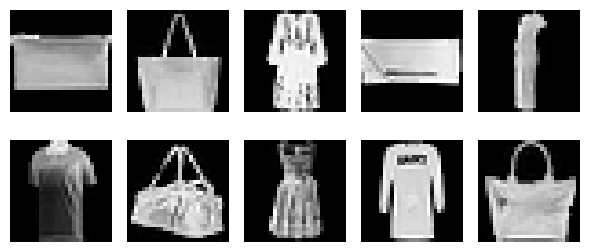

In [12]:
# Выведем изображения нескольких образцов для проверки датасета Train
# Выбираем 10 случайных индексов изображений.
random_indices = np.random.choice(X_train.shape[0], 10, replace=False)

# Визуализация 10 случайных изображений.
fig, axes = plt.subplots(2, 5, figsize=(6, 3)) 
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[random_indices[i]], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


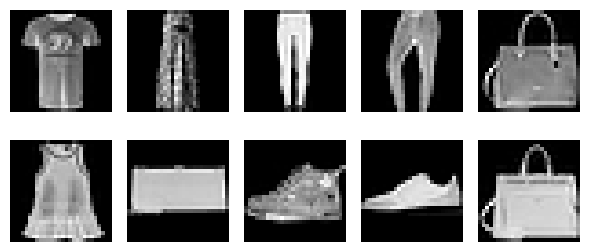

In [13]:
# Выведем изображения нескольких образцов для проверки датасета Val
# Выбираем 10 случайных индексов изображений.
random_indices = np.random.choice(val_cleaned.shape[0], 10, replace=False)

# Визуализация 10 случайных изображений.
fig, axes = plt.subplots(2, 5, figsize=(6, 3)) 
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[random_indices[i]], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [14]:
# Сбросим стандартный стек графа
tf.compat.v1.reset_default_graph()

# Обучение модели для CNN
cnn_model = tf.keras.Sequential([
    # Слой Input определяет форму входных данных.
    tf.keras.layers.Input(shape=(28, 28, 1)),
    # Первый сверточный слой с 32 фильтрами, ядром - 3х3 с сохранение размера выхода и функцией активайии ReLu
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    # Первый пуллинг слой с окном 2х2 для уменьшения размеров картинки в 2 раза (шаг - 2)
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # Второй сверточный слой с 64 фильтрами
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    # Второй пуллинг слой
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # Перевод в вектор
    tf.keras.layers.Flatten(),
    # Полносвязный слой с 10 узлами и функцией активации softmax для вероятностей классов
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

2024-05-12 18:47:08.767776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-12 18:47:08.768057: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
# Сводка модели
cnn_model.summary()

# Компилируем модель
cnn_model.compile(
    optimizer = 'adam',
    # Использую SparseCategoricalCrossentropy так как классы представлены целыми числами
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Снижаем скорость обучения, когда val_loss перестает улучшаться
reduce_learning = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

# Останавливаем обучение, когда val_loss перестает улучшаться
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [17]:
# Обучение модели
history = cnn_model.fit(
    X_train, 
    y_train, 
    epochs = 15, 
    verbose=2, 
    validation_data=(X_test, y_test),
    callbacks=callbacks)

Epoch 1/15


2024-05-12 18:47:08.912572: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48090560 exceeds 10% of free system memory.


480/480 - 6s - 13ms/step - accuracy: 0.7744 - loss: 0.6154 - val_accuracy: 0.8357 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 2/15
480/480 - 5s - 11ms/step - accuracy: 0.8580 - loss: 0.3947 - val_accuracy: 0.8633 - val_loss: 0.3906 - learning_rate: 0.0010
Epoch 3/15
480/480 - 5s - 11ms/step - accuracy: 0.8741 - loss: 0.3474 - val_accuracy: 0.8820 - val_loss: 0.3375 - learning_rate: 0.0010
Epoch 4/15
480/480 - 5s - 10ms/step - accuracy: 0.8883 - loss: 0.3114 - val_accuracy: 0.8897 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 5/15
480/480 - 5s - 10ms/step - accuracy: 0.8996 - loss: 0.2803 - val_accuracy: 0.8879 - val_loss: 0.3322 - learning_rate: 0.0010
Epoch 6/15
480/480 - 5s - 10ms/step - accuracy: 0.9081 - loss: 0.2561 - val_accuracy: 0.8926 - val_loss: 0.2941 - learning_rate: 0.0010
Epoch 7/15
480/480 - 5s - 10ms/step - accuracy: 0.9117 - loss: 0.2397 - val_accuracy: 0.9020 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 8/15
480/480 - 5s - 11ms/step - accuracy: 0.9195 - lo

Text(0.5, 1.0, 'Динамика Accuracy')

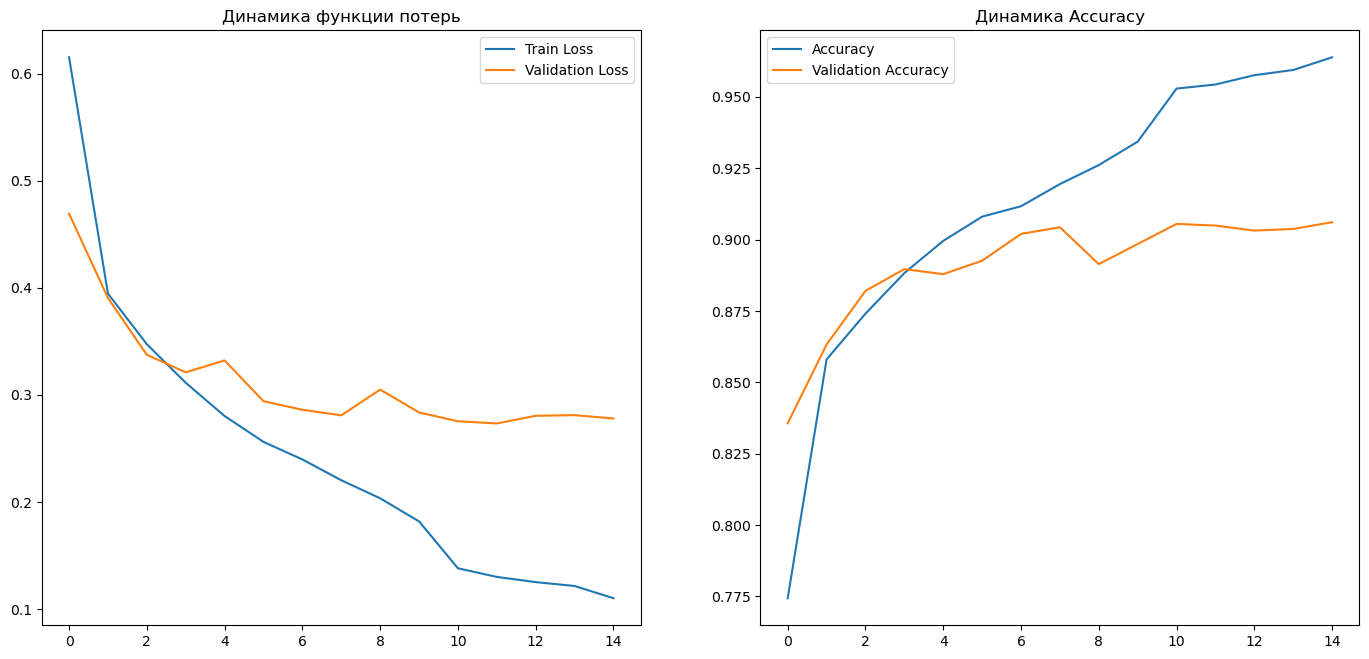

In [23]:
# Выводим график обучения модели
plt.figure(figsize=(17,17))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Динамика функции потерь')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Динамика Accuracy')

**Выводы:**
    
1) Как мы можем видить на графиках функция потерь уменьшается с каждой эпохой для тренировочного набора данных, в то время как на тестовом наборе начинает увеличиваться после 3 эпохи и снова снижаться после 6 эпохи.

2) Подтверждение первому выводу, мы можем увидеть на втором графике - Accuracy для тренировчного увеличивается с каждой эпохой, в то время как на тестовом наборе данных начинает уменьшаться после 3 эпохи, с новым пиком после 6 эпохи

3) Колебания графиков связаны с тем, что мы задавали изменения скорости обучения и шага при отсутсвии измений целевой метрики.


In [19]:
# Предсказывания для валидационного набора данных
predictions = cnn_model.predict(val_cleaned)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [20]:
# Преобразуем вероятности в индексы классов с максимальной вероятностью
predicted_labels = np.argmax(predictions, axis=1)

# Преобразуем Series в DataFrame
submission_df = sample_submission.to_frame(name='Id')

# Добавляем столбец с предсказанными метками классов
submission_df['label'] = predicted_labels

# Проверяем результат
print(submission_df.head())

   Id  label
0   0      0
1   1      1
2   2      2
3   3      6
4   4      3


In [21]:
# Сохраняем результат в виде .csv
submission_df.to_csv('sample_submission.csv', index=False)

In [22]:
import zipfile

# Создаем  ZIP-архив
with zipfile.ZipFile('sample_submission.zip', 'w') as zipf:
    zipf.write('sample_submission.csv', arcname='sample_submission.csv')